In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import itertools
import pickle


In [37]:
def generate_fully_connected_graph(n_nodes):
    # Create a complete graph adjacency matrix (no self-loops)
    adj_matrix = np.ones((n_nodes, n_nodes), dtype=np.int32) - np.eye(n_nodes, dtype=np.int32)

    # Create a rustworkx PyGraph
    graph_ = rx.PyGraph()
    graph_.add_nodes_from(range(n_nodes))

    for i in range(n_nodes):
        for j in range(i+1, n_nodes):  # Upper triangle to avoid duplicates
            graph_.add_edge(i, j, 1.0)

    return adj_matrix, graph_

In [6]:
import random

def generate_k_regular_graph(n_nodes, degree):
    if degree >= n_nodes or (n_nodes * degree) % 2 != 0:
        raise ValueError("Invalid degree: must be < n_nodes and n_nodes * degree must be even")

    # Initialize empty adjacency list
    adj_list = {i: set() for i in range(n_nodes)}
    attempts = 0
    max_attempts = 1000

    while attempts < max_attempts:
        # Try to build a random regular graph
        nodes = list(range(n_nodes))
        stubs = nodes * degree
        random.shuffle(stubs)

        adj_list = {i: set() for i in range(n_nodes)}
        success = True
        while stubs:
            a = stubs.pop()
            if not stubs:
                success = False
                break
            b = stubs.pop()

            if a == b or b in adj_list[a] or len(adj_list[a]) >= degree or len(adj_list[b]) >= degree:
                # Retry with new shuffle
                success = False
                break

            adj_list[a].add(b)
            adj_list[b].add(a)

        if success and all(len(neighbors) == degree for neighbors in adj_list.values()):
            break

        attempts += 1

    if not success:
        raise ValueError("Failed to generate k-regular graph after many attempts")

    # Build adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.int32)
    for i, neighbors in adj_list.items():
        for j in neighbors:
            adj_matrix[i, j] = 1

    # Build rustworkx graph
    graph_ = rx.PyGraph()
    graph_.add_nodes_from(range(n_nodes))
    for i in range(n_nodes):
        for j in adj_list[i]:
            if i < j:  # Avoid duplicate edges
                graph_.add_edge(i, j, 1.0)

    return adj_matrix, graph_

In [8]:
def generate_connected_er_graphs(n_nodes, batch_size, p_connection, seed=None):
    if seed is not None:
        np.random.seed(seed)

    batch = np.zeros((batch_size, n_nodes, n_nodes), dtype=np.int32)

    for b in range(batch_size):
        connected = False
        while not connected:
            g = nx.erdos_renyi_graph(n_nodes, p_connection)
            connected = nx.is_connected(g)

        # Convert to adjacency matrix
        adj = nx.to_numpy_array(g, dtype=np.int32)
        np.fill_diagonal(adj, 0)  # No self-loops

        batch[b] = adj

    return batch

# Parameters
n = 10
p_connection = 0.4
adj_matrix  = generate_connected_er_graphs(n, 1, p_connection, None)[0]

# Create a rustworkx PyGraph
graph_ = rx.PyGraph()
graph_.add_nodes_from(np.arange(n))

# Add edges from adjacency matrix
for i in range(n):
    for j in range(i+1, n):  # Only upper triangle to avoid duplicates
        if adj_matrix[i, j] == 1:
            graph_.add_edge(i, j, 1.0)



In [38]:
adj_matrix, graph_ = generate_k_regular_graph(n_nodes=10, degree=4)

In [ ]:
# adj_matrix, graph_ = generate_fully_connected_graph(10)

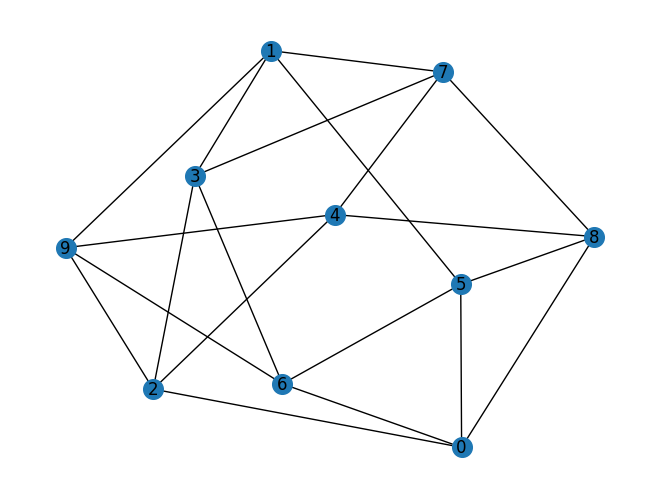

In [41]:
# Draw (you can use your existing draw_graph function)
draw_graph(graph_, node_size=200, with_labels=True, width=1)

In [36]:
# Save
with open("10_graph_25_complete.pkl", "wb") as f:
    pickle.dump(graph_, f)


In [43]:
# Load
with open("25_graph_83.pkl", "rb") as f:
    g_loaded = pickle.load(f)

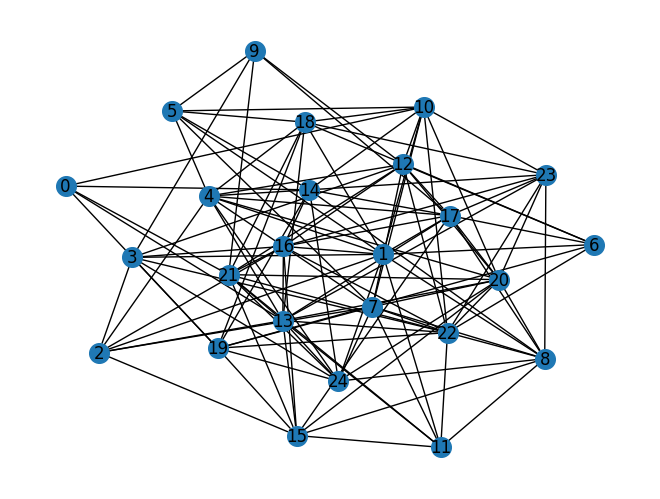

In [44]:
draw_graph(g_loaded, node_size=200, with_labels=True, width=1)